# <span style='color:purple'> PROJECT : AMAZON ALEXA SENTIMENT ANALYSIS

import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
nltk.download('stopwords')
stopword = stopwords.words('english')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier

from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import pickle
import re
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


load dataset

In [2]:
data = pd.read_csv('C:\\Users\\Lenovo\\Downloads\\amazon_alexa.tsv', sep='\t')

In [3]:
# display the dataset
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [4]:
print('Feature names :', data.columns)

Feature names : Index(['rating', 'date', 'variation', 'verified_reviews', 'feedback'], dtype='object')


check null values present in the dataset

In [5]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    1
feedback            0
dtype: int64

In [6]:
# drop the null value
data.dropna(inplace=True)


In [7]:
data.isna().sum()

rating              0
date                0
variation           0
verified_reviews    0
feedback            0
dtype: int64

In [8]:
data.shape

(3149, 5)

In [9]:
data['length'] = data['verified_reviews'].apply(len)

In [10]:
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


information of the dataset

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3149 entries, 0 to 3149
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   rating            3149 non-null   int64 
 1   date              3149 non-null   object
 2   variation         3149 non-null   object
 3   verified_reviews  3149 non-null   object
 4   feedback          3149 non-null   int64 
 5   length            3149 non-null   int64 
dtypes: int64(3), object(3)
memory usage: 172.2+ KB


### Analysing the rating column

In [12]:
data['rating'].value_counts()

rating
5    2286
4     455
1     161
3     152
2      95
Name: count, dtype: int64

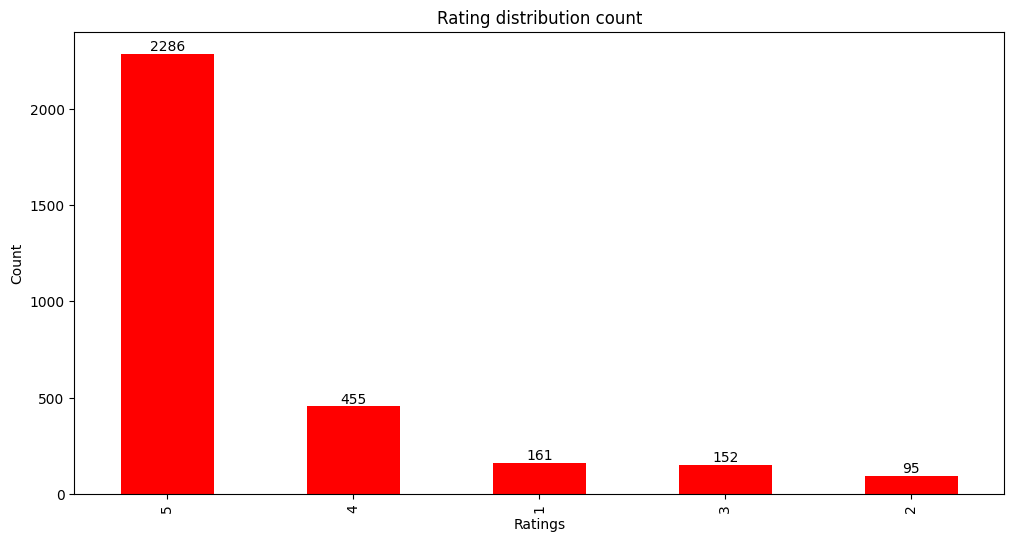

In [13]:
# barplot to display the data 
plt.figure(figsize=(12,6))
ax = data['rating'].value_counts().plot.bar(color = 'red')
for bars in ax.containers:
    ax.bar_label(bars)
plt.title('Rating distribution count')
plt.xlabel('Ratings')
plt.ylabel('Count')
plt.show()

In [14]:
print(data['rating'].value_counts()/data.shape[0]*100)

rating
5    72.594474
4    14.449031
1     5.112734
3     4.826929
2     3.016831
Name: count, dtype: float64


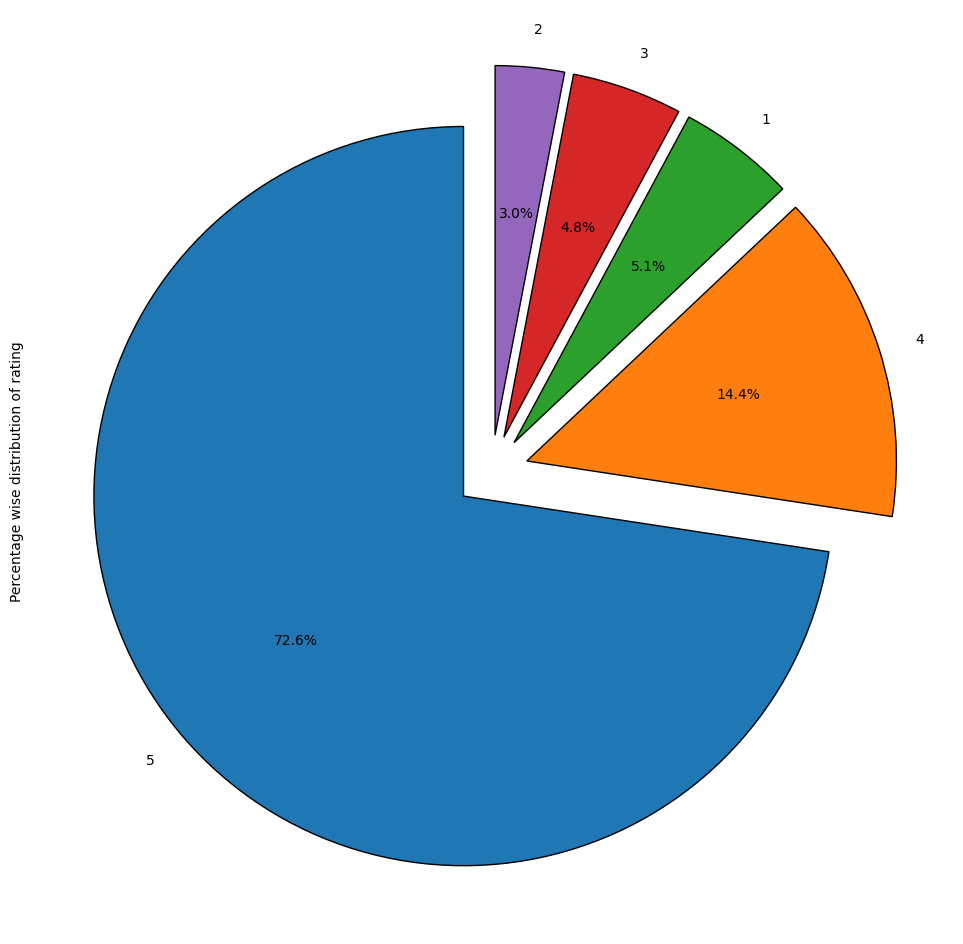

In [15]:
plt.figure(figsize=(12,12))
colors = ('red','green','blue','orange','yellow')
wp = {'linewidth':1, 'edgecolor':'black'}
tags = data['rating'].value_counts()/data.shape[0]
explode = (0.1,0.1,0.1,0.1,0.1)
tags.plot(kind='pie', autopct='%1.1f%%',  color=colors, startangle=90, wedgeprops = wp, explode=explode, label='Percentage wise distribution of rating')
from io import BytesIO
graph = BytesIO()
plt.savefig(graph, format='png')
plt.show()

### Analyzing feedback column

In [16]:
data['feedback'].value_counts()

feedback
1    2893
0     256
Name: count, dtype: int64

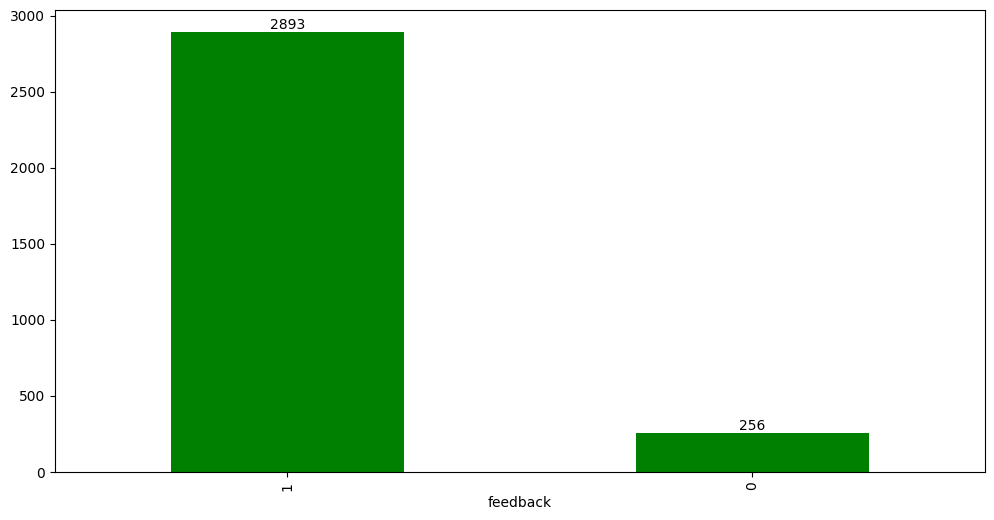

In [17]:
plt.figure(figsize=(12,6))
ax = data['feedback'].value_counts().plot.bar(color='green')
for bars in ax.containers:
    ax.bar_label(bars)
plt.show()

In [18]:
data['feedback'].value_counts()/data.shape[0]*100

feedback
1    91.870435
0     8.129565
Name: count, dtype: float64

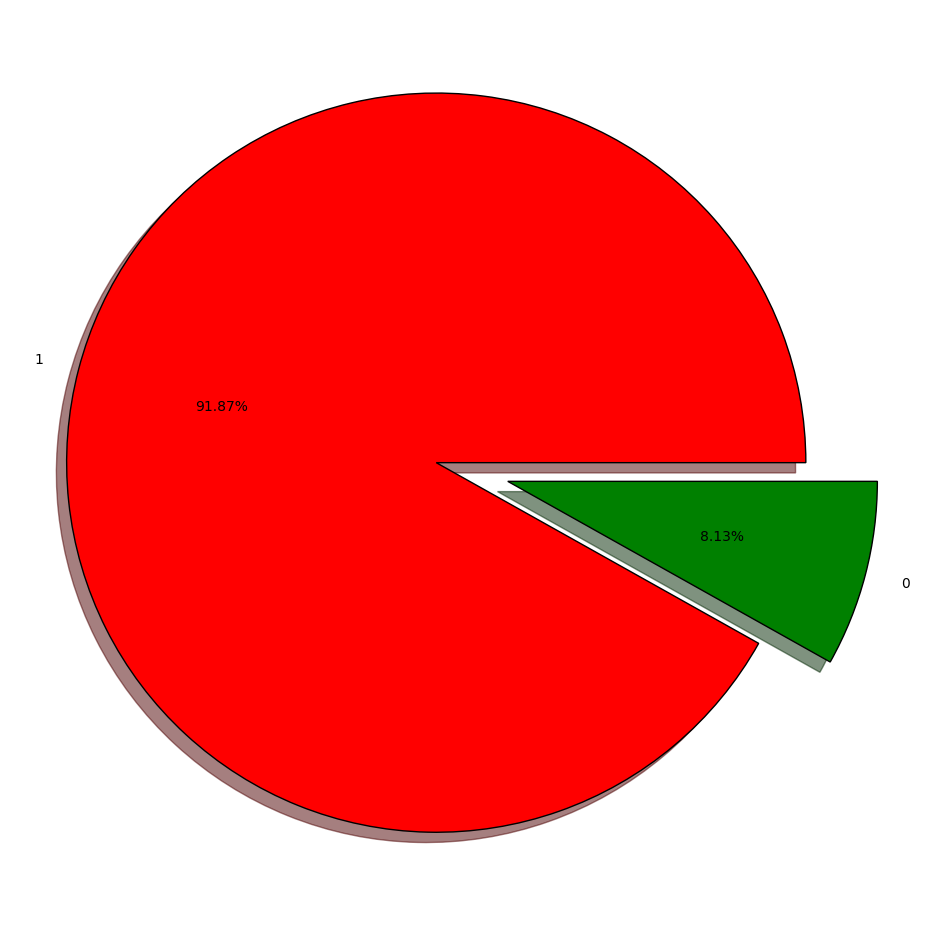

In [19]:
plt.figure(figsize=(12,12))
import matplotlib.pyplot as plt
wp = {'linewidth':1, "edgecolor":'black'}
explode=(0.1,0.1)
plt.pie(data['feedback'].value_counts(),wedgeprops=wp,colors=['red', 'green'], shadow=True,explode=explode, labels = data['feedback'].unique(), autopct='%.2f%%')
plt.show()

### Analyzing feedback with respect to rating

In [20]:
data[data['feedback'] == 0]['rating'].value_counts()

rating
1    161
2     95
Name: count, dtype: int64

In [21]:
data[data['feedback'] == 1]['rating'].value_counts()

rating
5    2286
4     455
3     152
Name: count, dtype: int64

### Analyzing variation column

In [22]:
data['variation'].value_counts()

variation
Black  Dot                      516
Charcoal Fabric                 430
Configuration: Fire TV Stick    350
Black  Plus                     270
Black  Show                     265
Black                           261
Black  Spot                     241
White  Dot                      184
Heather Gray Fabric             157
White  Spot                     109
Sandstone Fabric                 90
White                            90
White  Show                      85
White  Plus                      78
Oak Finish                       14
Walnut Finish                     9
Name: count, dtype: int64

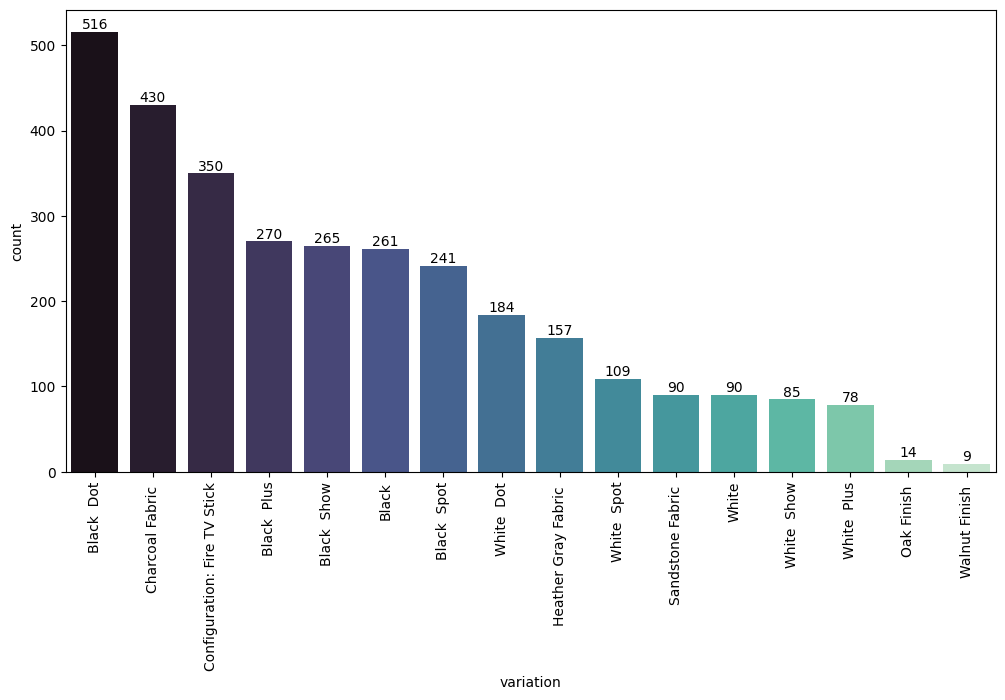

In [23]:
plt.figure(figsize=(12,6))
ax = sns.countplot(data=data , x='variation',palette='mako',order=data['variation'].value_counts(ascending=False).index)
for bars in ax.containers:
    ax.bar_label(bars)
plt.xticks(rotation=90)
plt.show()

In [24]:
print(data['variation'].value_counts()/data.shape[0]*100)

variation
Black  Dot                      16.386154
Charcoal Fabric                 13.655129
Configuration: Fire TV Stick    11.114640
Black  Plus                      8.574151
Black  Show                      8.415370
Black                            8.288346
Black  Spot                      7.653223
White  Dot                       5.843125
Heather Gray Fabric              4.985710
White  Spot                      3.461416
Sandstone Fabric                 2.858050
White                            2.858050
White  Show                      2.699270
White  Plus                      2.476977
Oak Finish                       0.444586
Walnut Finish                    0.285805
Name: count, dtype: float64


### groupby variation and rating

In [25]:
data.groupby('variation')['rating'].mean()

variation
Black                           4.233716
Black  Dot                      4.453488
Black  Plus                     4.370370
Black  Show                     4.490566
Black  Spot                     4.311203
Charcoal Fabric                 4.730233
Configuration: Fire TV Stick    4.591429
Heather Gray Fabric             4.694268
Oak Finish                      4.857143
Sandstone Fabric                4.355556
Walnut Finish                   4.888889
White                           4.166667
White  Dot                      4.423913
White  Plus                     4.358974
White  Show                     4.282353
White  Spot                     4.311927
Name: rating, dtype: float64

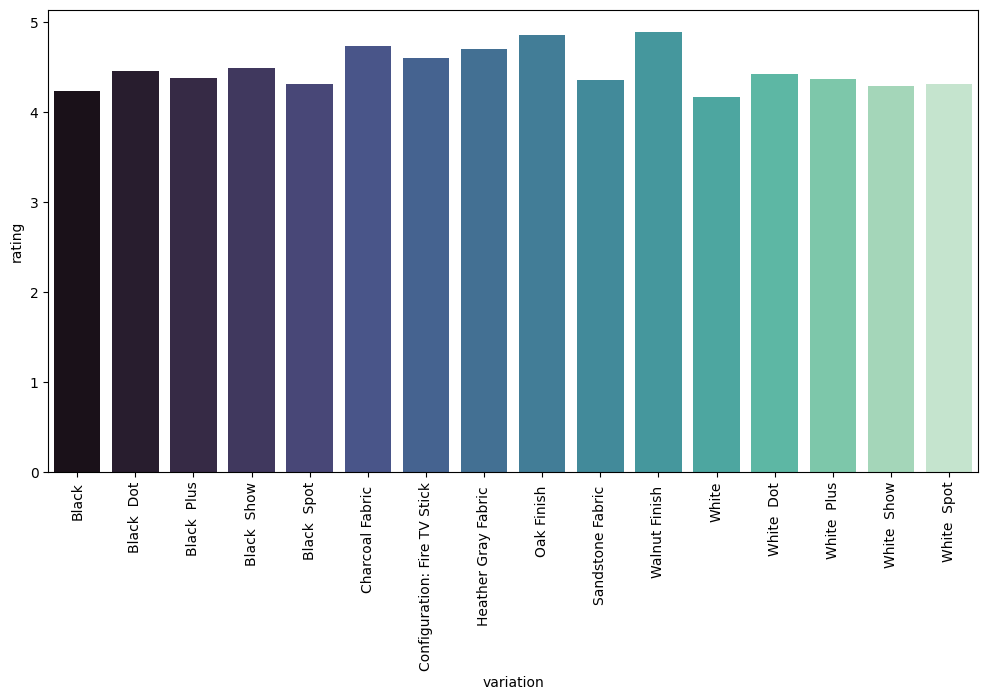

In [26]:
plt.figure(figsize=(12,6))
sns.barplot(x=data.groupby('variation')['rating'].mean().index,y=data.groupby('variation')['rating'].mean(),palette='mako')
plt.xticks(rotation = 90)
plt.show()

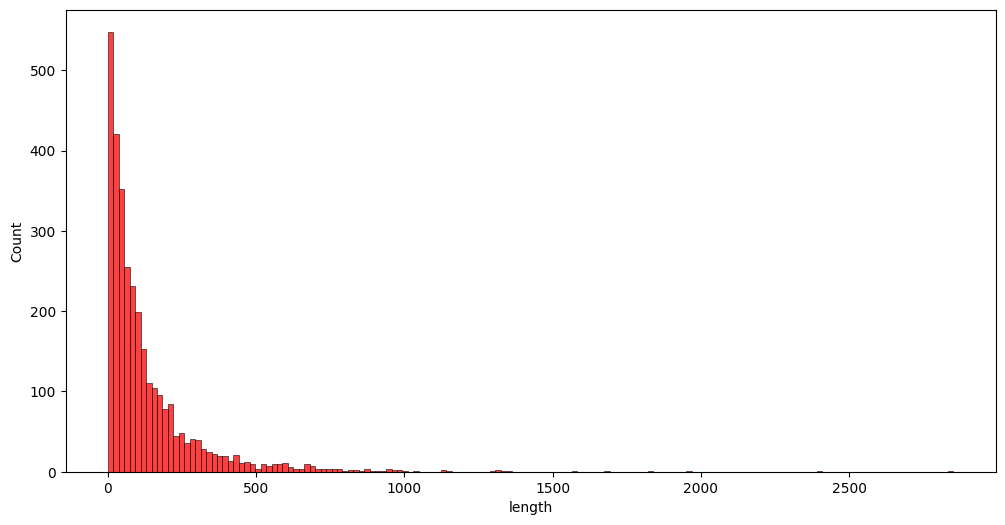

In [27]:
plt.figure(figsize=(12,6))
sns.histplot(data = data['length'], color='red')
plt.show()

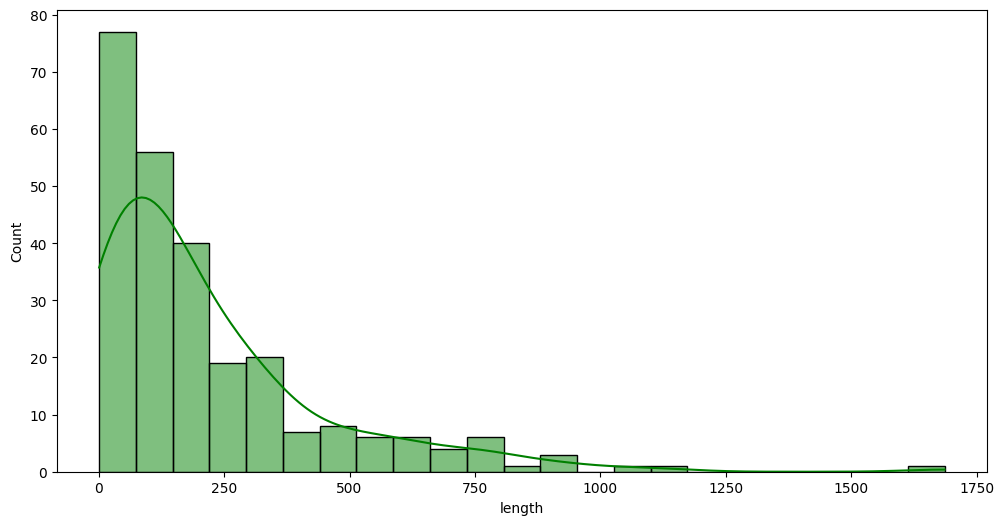

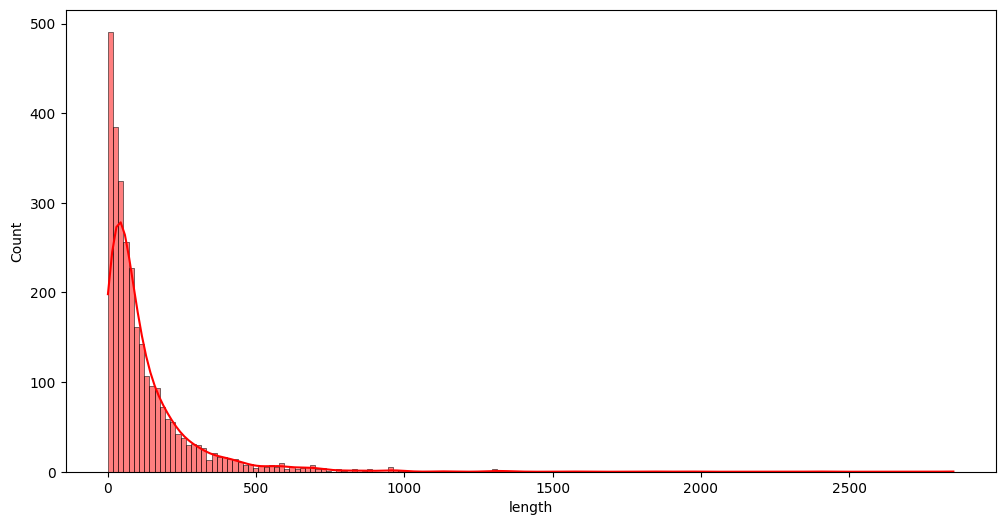

In [28]:
plt.figure(figsize=(12,6))
sns.histplot(data[data['feedback'] == 0]['length'] , color='green', kde=True)
plt.show()

plt.figure(figsize=(12,6))
sns.histplot(data[data['feedback'] == 1]['length'] , color='red', kde=True)
plt.show()

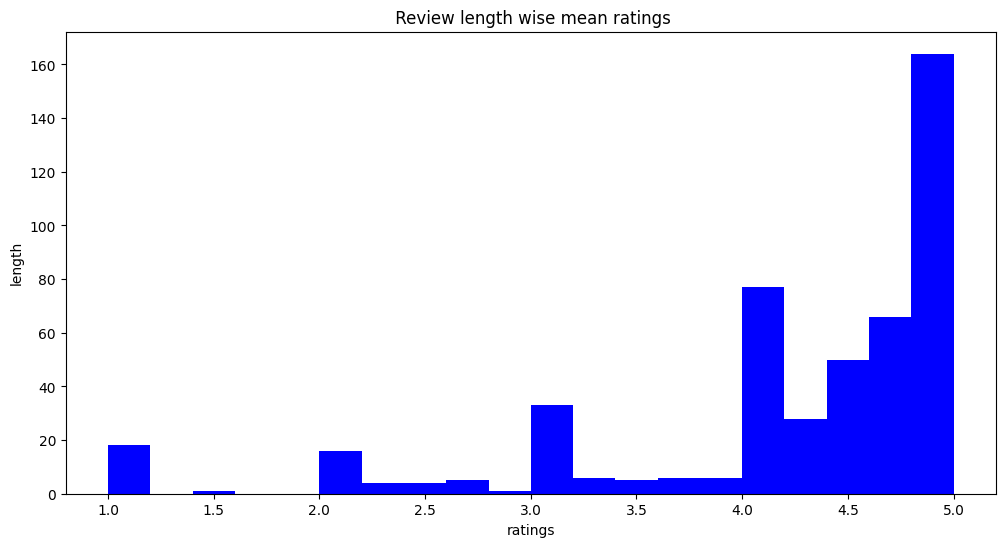

In [29]:
plt.figure(figsize=(12,6))
data.groupby('length')['rating'].mean().plot.hist(color = 'blue', bins = 20)
plt.title(" Review length wise mean ratings")
plt.xlabel('ratings')
plt.ylabel('length')
plt.show()

In [30]:
cv = CountVectorizer()
words = cv.fit_transform(data['verified_reviews'])

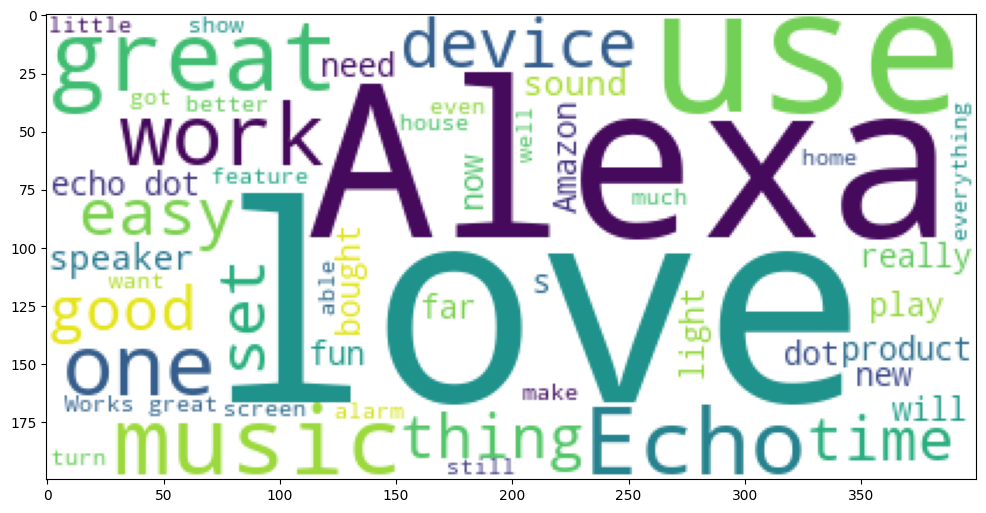

In [31]:
reviews = ". ".join([review for review in data['verified_reviews']])

wc = WordCloud(background_color='white', max_words = 50)

plt.figure(figsize=(12,8))
plt.imshow(wc.generate(reviews))
plt.show()

In [32]:
negative_reviews = ". ".join([review for review in data[data['feedback'] == 0]['verified_reviews']])
positive_reviews = ". ".join([review for review in data[data['feedback'] == 1]['verified_reviews']])

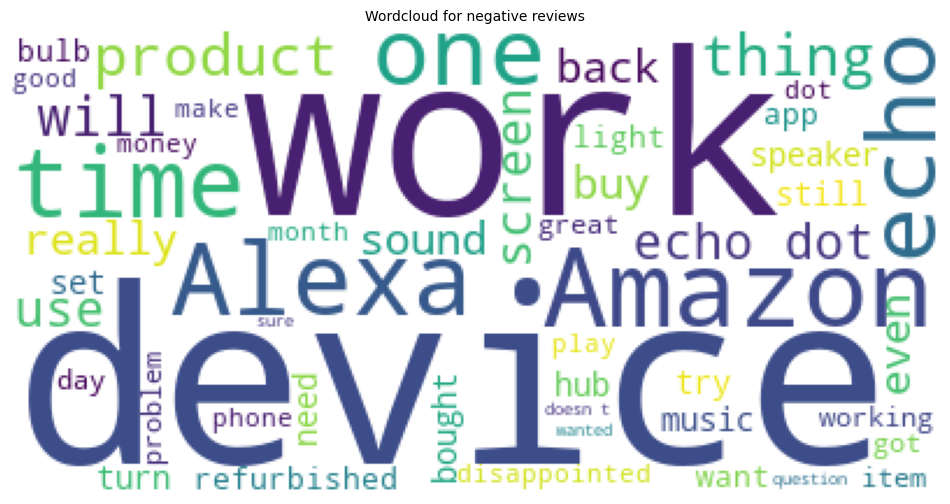

In [33]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(12,8))
plt.imshow(wc.generate(negative_reviews))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

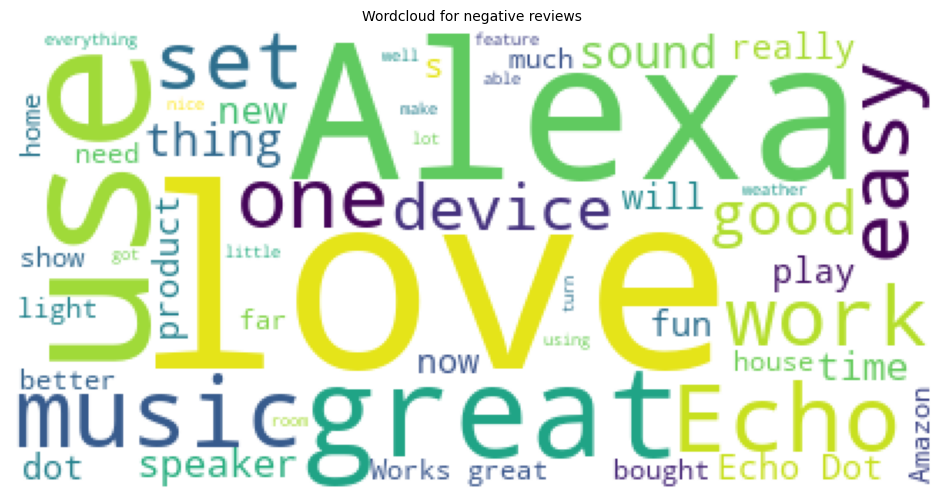

In [34]:
wc = WordCloud(background_color='white', max_words=50)

# Generate and plot wordcloud
plt.figure(figsize=(12,6))
plt.imshow(wc.generate(positive_reviews))
plt.title('Wordcloud for negative reviews', fontsize=10)
plt.axis('off')
plt.show()

In [35]:
corpus = []
stemmer = PorterStemmer()
for i in range(0, data.shape[0]):
  review = re.sub('[^a-zA-Z]',' ', data.iloc[i]['verified_reviews'])
  review = review.lower()
  review = review.split()
  review = [stemmer.stem(word) for word in review if not word in set(stopword)]
  review = ' '.join(review)
  corpus.append(review)

In [36]:
cv = CountVectorizer()
X = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=15)

In [38]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [39]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)
print('Accuracy Score :', accuracy_score(y_test, rf_pred))

Accuracy Score : 0.9417989417989417


In [40]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
xgb_pred = xgb.predict(X_test)
print('Accuracy Score :', accuracy_score(y_test, xgb_pred))

Accuracy Score : 0.9375661375661376


In [41]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
print('Accuracy Score :', accuracy_score(y_test, dt_pred))

Accuracy Score : 0.9227513227513228


In [42]:
import pickle
pickle.dump(rf, open('model.pkl', 'wb'))

In [43]:
from textblob import TextBlob

user_input = input("Enter a sentence: ")
blob = TextBlob(user_input)

# Polarity ranges from -1 (negative) to 1 (positive)
if blob.sentiment.polarity > 0 and  blob.sentiment.polarity <= 1:
    print("Positive")
elif blob.sentiment.polarity <= 0:
    print("Negative")
elif blob.sentiment.polarity > 1:
    print("Neutral")

Negative
